In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import torch
import shap
from sklearn.ensemble import RandomForestRegressor
import ast
import random



# Plot settings
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Save helper
def save_last_plot(filename):
    if not os.path.exists("../outputs"):
        os.makedirs("../outputs")
    plt.gcf().savefig(f"../outputs/{filename}", bbox_inches='tight')
    print(f"✅ Saved to outputs/{filename}")


In [85]:
instances_df = pd.read_csv("../data/tsp_instances_dataset.csv")
cities_df = pd.read_csv("../data/tsp_dataset.csv")


In [86]:
instance_id = cities_df["instance_id"].iloc[0]
selected_row = cities_df[cities_df["instance_id"] == instance_id].iloc[0]
coords = np.array(ast.literal_eval(selected_row["city_coordinates"]))

def compute_distance_matrix(coords):
    return np.linalg.norm(coords[:, None] - coords[None, :], axis=2)

distance_matrix = compute_distance_matrix(coords)


✅ Saved to outputs/instance_map.png
✅ Saved to outputs/nn_tour.png
✅ Saved to outputs/2opt_tour.png
✅ Saved to outputs/ga_tour.png
✅ Saved to outputs/aco_tour.png
✅ Saved to outputs/rl_tour.png


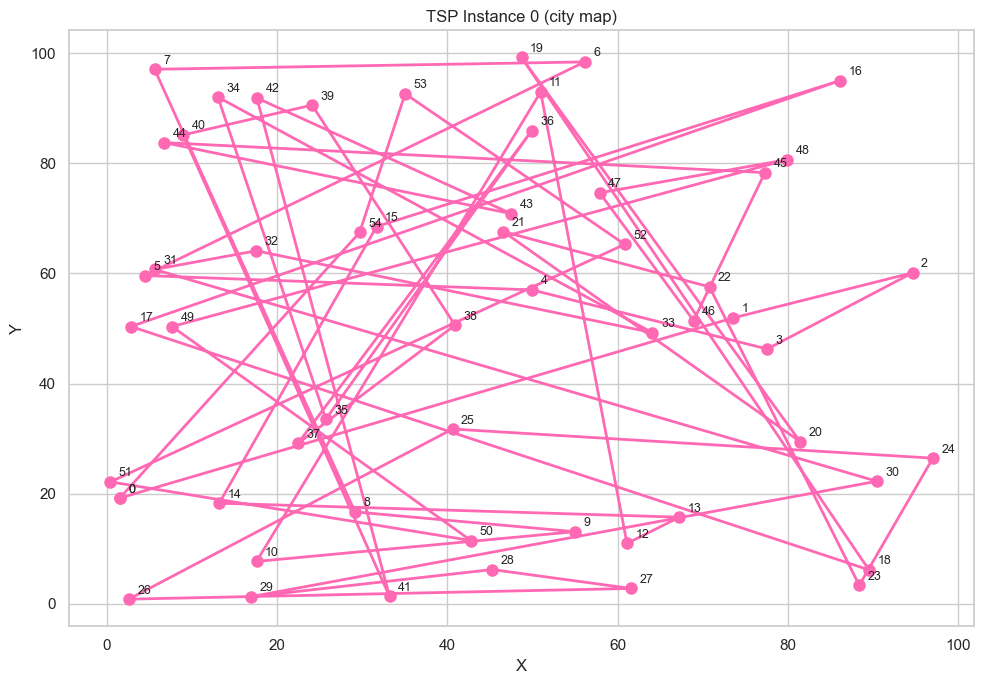

In [87]:
def plot_tour(coords, tour, title="TSP Tour"):
    plt.figure(figsize=(10, 7))
    ordered_coords = coords[tour]
    plt.plot(ordered_coords[:, 0], ordered_coords[:, 1], 'o-', color="hotpink", linewidth=2, markersize=8)
    for i, (x, y) in enumerate(ordered_coords):
        plt.text(x + 1, y + 1, str(tour[i]), fontsize=9)
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.tight_layout()
    save_last_plot("instance_map.png")
    save_last_plot("nn_tour.png")
    save_last_plot("2opt_tour.png")
    save_last_plot("ga_tour.png")
    save_last_plot("aco_tour.png")
    save_last_plot("rl_tour.png")
    plt.show()

plot_tour(coords, list(range(len(coords))) + [0], f"TSP Instance {instance_id} (city map)")



✅ Saved to outputs/instance_map.png
✅ Saved to outputs/nn_tour.png
✅ Saved to outputs/2opt_tour.png
✅ Saved to outputs/ga_tour.png
✅ Saved to outputs/aco_tour.png
✅ Saved to outputs/rl_tour.png


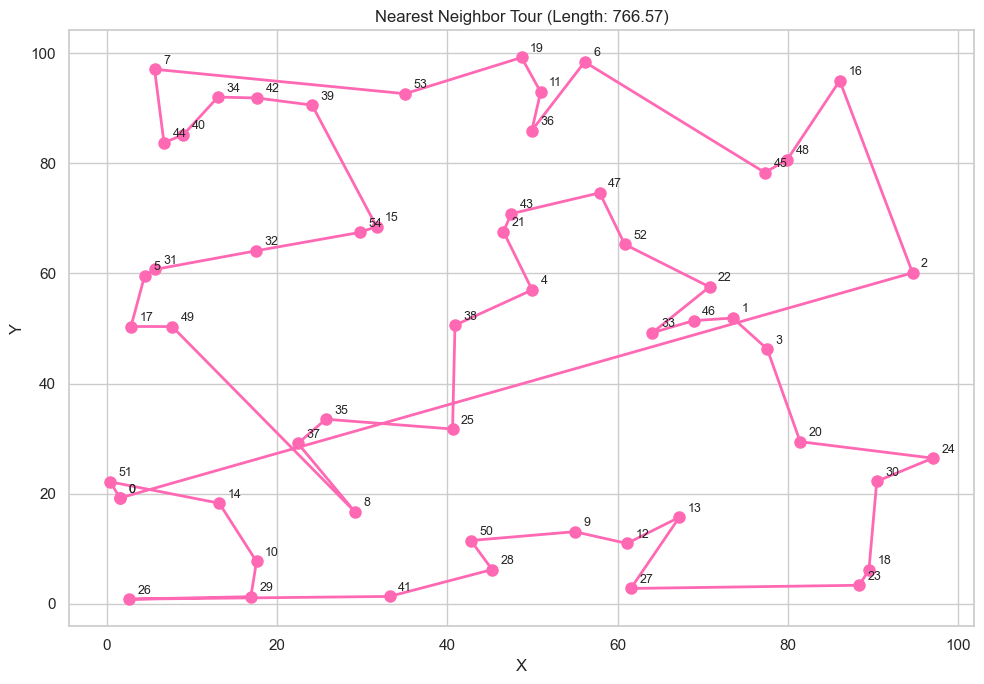

In [88]:
def nearest_neighbor(distance_matrix):
    N = len(distance_matrix)
    visited = [0]
    for _ in range(N - 1):
        last = visited[-1]
        next_city = np.argmin([distance_matrix[last][j] if j not in visited else np.inf for j in range(N)])
        visited.append(next_city)
    return visited

nn_tour = nearest_neighbor(distance_matrix)
nn_length = sum(distance_matrix[nn_tour[i]][nn_tour[i+1]] for i in range(len(nn_tour)-1)) + distance_matrix[nn_tour[-1]][nn_tour[0]]

plot_tour(coords, nn_tour + [nn_tour[0]], f"Nearest Neighbor Tour (Length: {nn_length:.2f})")



✅ Saved to outputs/instance_map.png
✅ Saved to outputs/nn_tour.png
✅ Saved to outputs/2opt_tour.png
✅ Saved to outputs/ga_tour.png
✅ Saved to outputs/aco_tour.png
✅ Saved to outputs/rl_tour.png


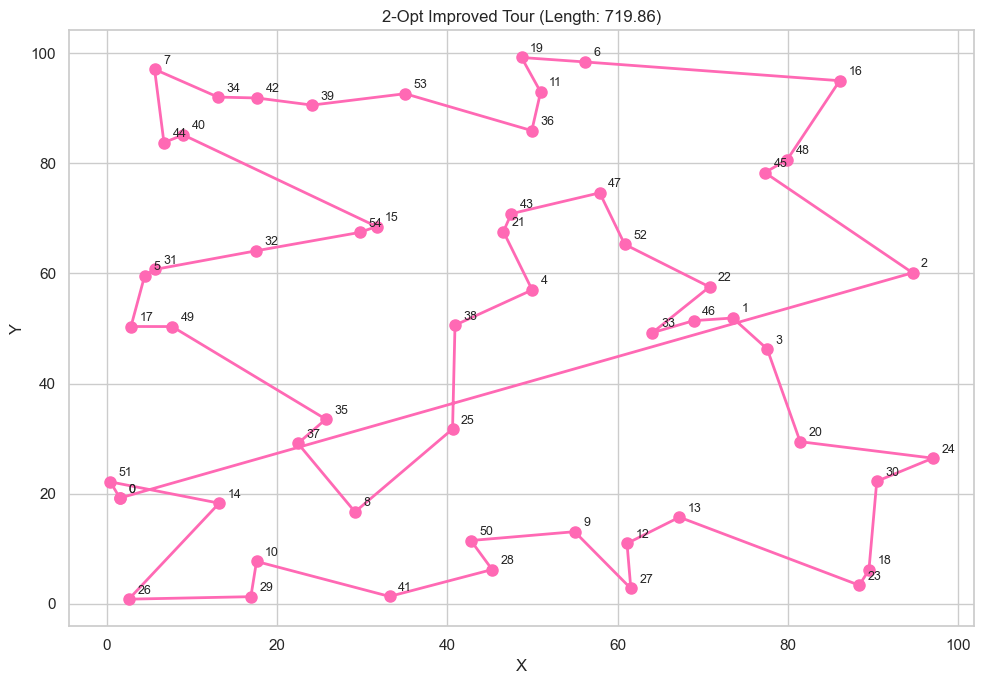

In [89]:
def two_opt(tour, dist_matrix):
    best = tour
    improved = True
    while improved:
        improved = False
        for i in range(1, len(tour) - 2):
            for j in range(i + 1, len(tour)):
                if j - i == 1: continue
                new = best[:]
                new[i:j] = best[j-1:i-1:-1]
                if sum(dist_matrix[new[k]][new[k+1]] for k in range(len(new)-1)) + dist_matrix[new[-1]][new[0]] < \
                   sum(dist_matrix[best[k]][best[k+1]] for k in range(len(best)-1)) + dist_matrix[best[-1]][best[0]]:
                    best = new
                    improved = True
    return best

improved_tour = two_opt(nn_tour, distance_matrix)
improved_length = sum(distance_matrix[improved_tour[i]][improved_tour[i+1]] for i in range(len(improved_tour)-1)) + distance_matrix[improved_tour[-1]][improved_tour[0]]

plot_tour(coords, improved_tour + [improved_tour[0]], f"2-Opt Improved Tour (Length: {improved_length:.2f})")


GA Evolving: 100%|██████████| 200/200 [00:00<00:00, 349.35it/s]


✅ Saved to outputs/instance_map.png
✅ Saved to outputs/nn_tour.png
✅ Saved to outputs/2opt_tour.png
✅ Saved to outputs/ga_tour.png
✅ Saved to outputs/aco_tour.png
✅ Saved to outputs/rl_tour.png


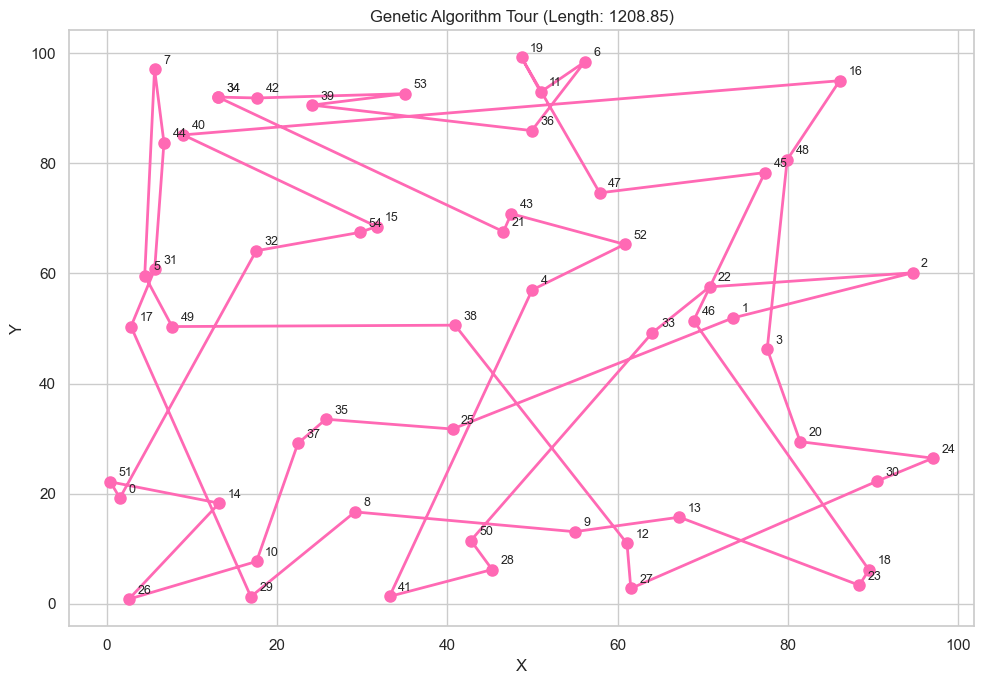

In [90]:
def genetic_algorithm(dist_matrix, n_generations=200, pop_size=100, mutation_rate=0.02):
    def create_individual():
        return np.random.permutation(len(dist_matrix)).tolist()

    def fitness(tour):
        return sum(dist_matrix[tour[i]][tour[i+1]] for i in range(len(tour)-1)) + dist_matrix[tour[-1]][tour[0]]

    def crossover(parent1, parent2):
        start, end = sorted(np.random.choice(range(len(parent1)), 2))
        child = [-1]*len(parent1)
        child[start:end+1] = parent1[start:end+1]
        fill = [city for city in parent2 if city not in child]
        ptr = 0
        for i in range(len(child)):
            if child[i] == -1:
                child[i] = fill[ptr]
                ptr += 1
        return child

    def mutate(tour):
        if np.random.rand() < mutation_rate:
            i, j = np.random.choice(len(tour), 2, replace=False)
            tour[i], tour[j] = tour[j], tour[i]

    population = [create_individual() for _ in range(pop_size)]
    for _ in tqdm(range(n_generations), desc="GA Evolving"):
        population = sorted(population, key=fitness)
        new_pop = population[:10]
        while len(new_pop) < pop_size:
            parents = random.sample(population[:50], 2)
            child = crossover(parents[0], parents[1])
            mutate(child)
            new_pop.append(child)
        population = new_pop

    best = population[0]
    return best, fitness(best)

ga_tour, ga_length = genetic_algorithm(distance_matrix)
plot_tour(coords, ga_tour + [ga_tour[0]], f"Genetic Algorithm Tour (Length: {ga_length:.2f})")


ACO Iteration: 100%|██████████| 100/100 [00:06<00:00, 14.94it/s]


✅ Saved to outputs/instance_map.png
✅ Saved to outputs/nn_tour.png
✅ Saved to outputs/2opt_tour.png
✅ Saved to outputs/ga_tour.png
✅ Saved to outputs/aco_tour.png
✅ Saved to outputs/rl_tour.png


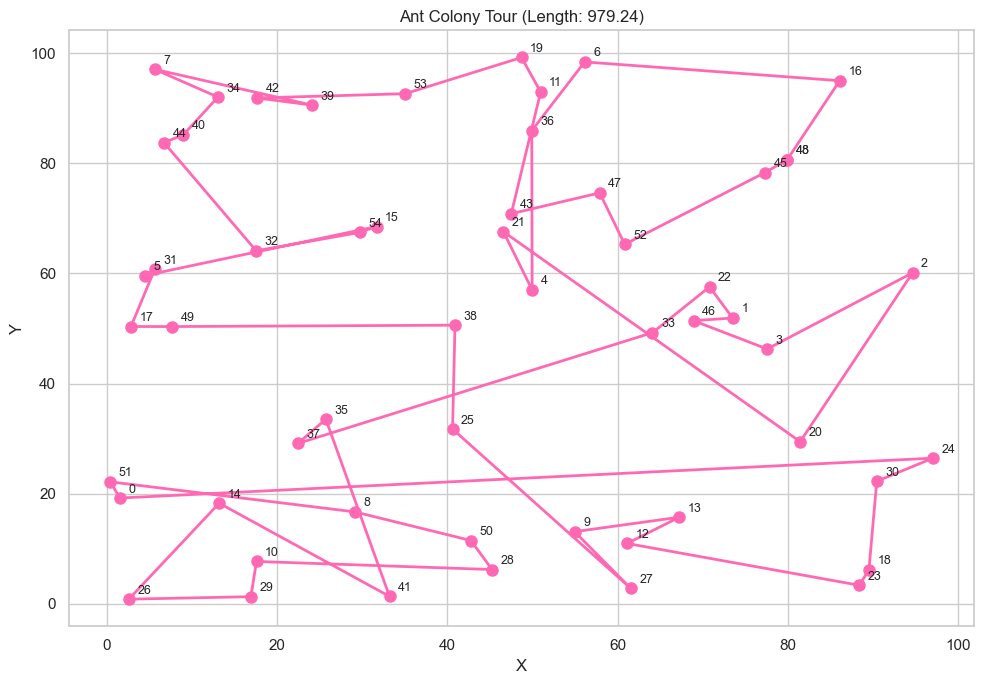

In [91]:
import random

def ant_colony_optimization(distance_matrix, n_ants=30, n_best=5, n_iterations=100, decay=0.95, alpha=1, beta=2):
    n_nodes = len(distance_matrix)
    pheromone = np.ones((n_nodes, n_nodes))
    best_distance = float("inf")
    best_tour = None

    for _ in tqdm(range(n_iterations), desc="ACO Iteration"):
        all_tours, all_distances = [], []
        for _ in range(n_ants):
            tour = [random.randint(0, n_nodes - 1)]
            for _ in range(n_nodes - 1):
                current = tour[-1]
                probs = []
                for city in range(n_nodes):
                    if city not in tour:
                        tau = pheromone[current][city] ** alpha
                        eta = (1 / distance_matrix[current][city]) ** beta
                        probs.append(tau * eta)
                    else:
                        probs.append(0)
                probs = np.array(probs)
                probs /= probs.sum()
                next_city = np.random.choice(range(n_nodes), p=probs)
                tour.append(next_city)
            tour_distance = sum(distance_matrix[tour[i]][tour[i + 1]] for i in range(n_nodes - 1)) + distance_matrix[tour[-1]][tour[0]]
            all_tours.append(tour)
            all_distances.append(tour_distance)

        pheromone *= decay
        for idx in np.argsort(all_distances)[:n_best]:
            tour = all_tours[idx]
            for i in range(n_nodes - 1):
                pheromone[tour[i]][tour[i + 1]] += 1.0 / all_distances[idx]
            pheromone[tour[-1]][tour[0]] += 1.0 / all_distances[idx]

        if min(all_distances) < best_distance:
            best_distance = min(all_distances)
            best_tour = all_tours[np.argmin(all_distances)]

    return best_tour, best_distance

aco_tour, aco_length = ant_colony_optimization(distance_matrix)
plot_tour(coords, aco_tour + [aco_tour[0]], f"Ant Colony Tour (Length: {aco_length:.2f})")


RL Simulation: 100%|██████████| 200/200 [00:00<00:00, 53687.09it/s]


✅ Saved to outputs/instance_map.png
✅ Saved to outputs/nn_tour.png
✅ Saved to outputs/2opt_tour.png
✅ Saved to outputs/ga_tour.png
✅ Saved to outputs/aco_tour.png
✅ Saved to outputs/rl_tour.png


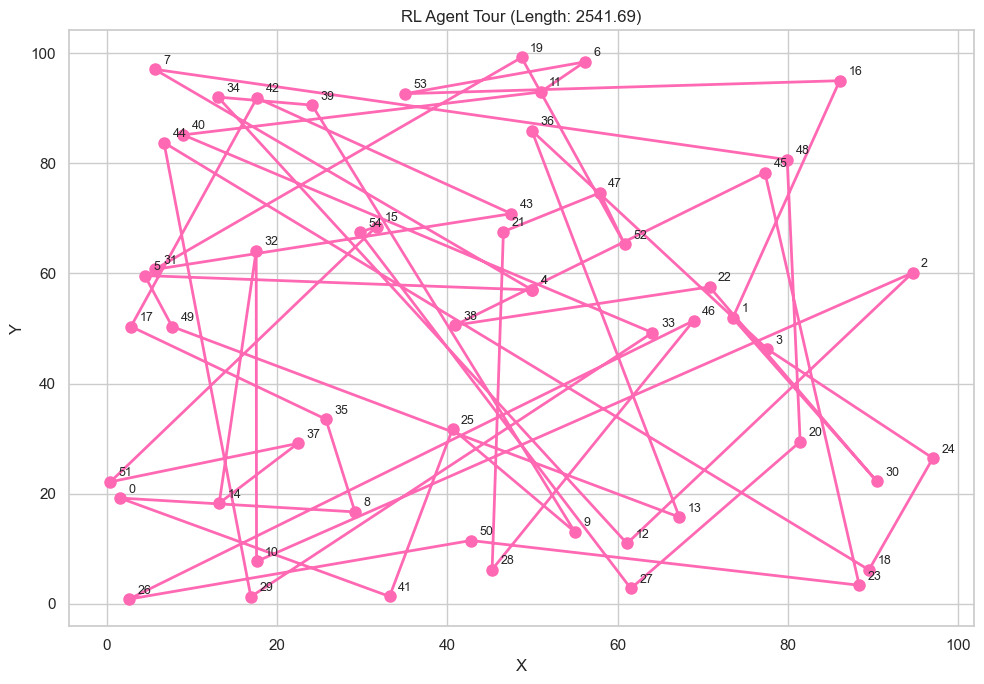

In [92]:
# 🔁 Simulated RL agent (random search baseline)
reward_progress = []
best_reward = float("inf")
best_rl_tour = None

for i in tqdm(range(200), desc="RL Simulation"):
    candidate = np.random.permutation(len(coords))
    total_dist = sum(distance_matrix[candidate[j]][candidate[j+1]] for j in range(len(candidate)-1)) + distance_matrix[candidate[-1]][candidate[0]]
    reward_progress.append(total_dist)
    if total_dist < best_reward:
        best_reward = total_dist
        best_rl_tour = candidate

rl_length = best_reward

plot_tour(coords, best_rl_tour.tolist() + [best_rl_tour[0]], f"RL Agent Tour (Length: {rl_length:.2f})")



✅ Saved to outputs/rl_reward_curve.png


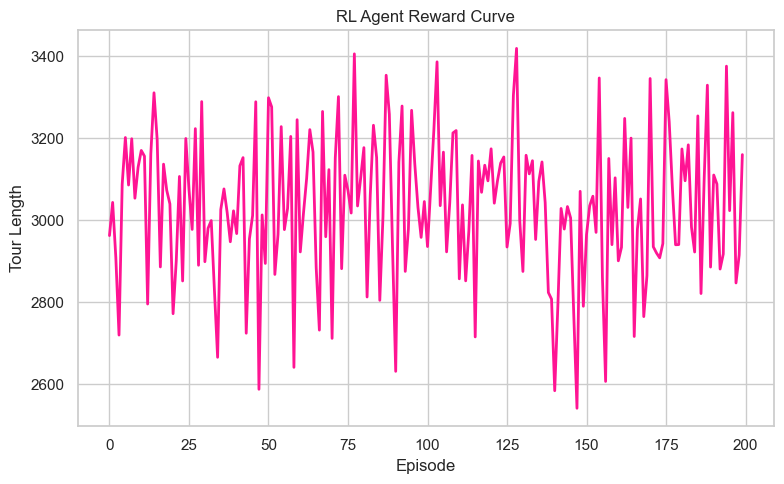

In [93]:
plt.figure(figsize=(8, 5))
plt.plot(reward_progress, color="deeppink", linewidth=2)
plt.title("RL Agent Reward Curve")
plt.xlabel("Episode")
plt.ylabel("Tour Length")
plt.grid(True)
plt.tight_layout()
save_last_plot("rl_reward_curve.png")
plt.show()


✅ Saved to outputs/shap_feature_importance.png


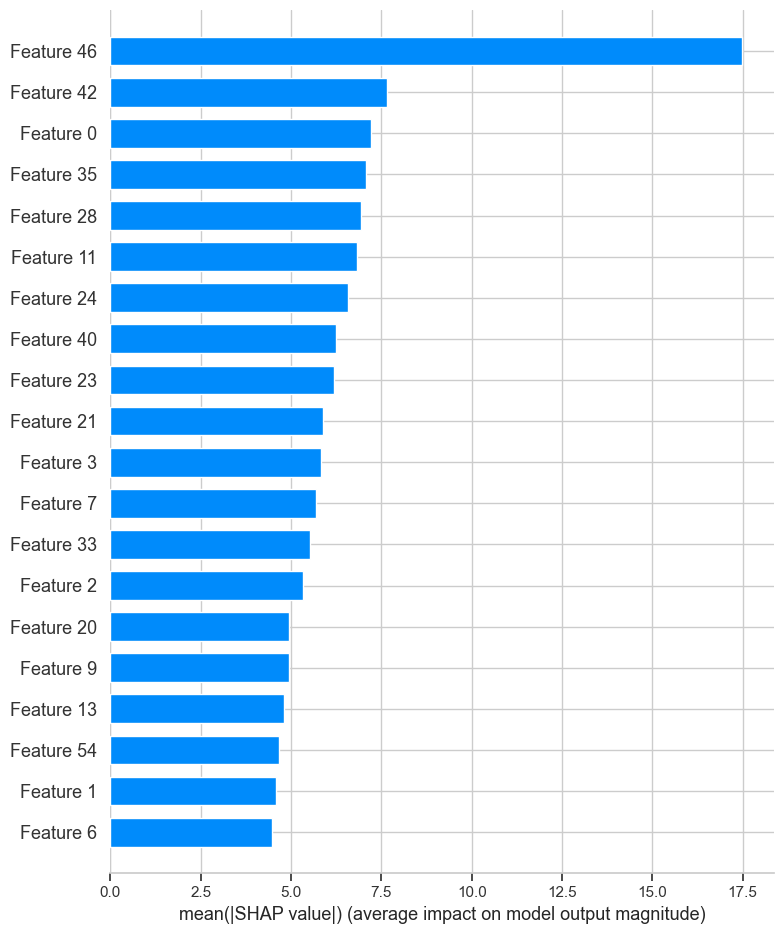

In [94]:
# 🧠 Build synthetic features for SHAP
X = []
y = []

for _ in range(1000):
    tour = np.random.permutation(len(coords))
    feat = [distance_matrix[tour[i]][tour[i + 1]] for i in range(len(tour) - 1)]
    feat.append(distance_matrix[tour[-1]][tour[0]])
    X.append(feat)
    y.append(sum(feat))

X = np.array([xi + [0] * (len(coords) - len(xi)) for xi in X])  # Padding
model = RandomForestRegressor().fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X[:100])

shap.summary_plot(shap_values, X[:100], plot_type="bar", show=False)
save_last_plot("shap_feature_importance.png")
plt.show()


In [95]:
summary_df = pd.DataFrame({
    "Method": ["Nearest Neighbor", "2-opt", "Genetic Algorithm", "Ant Colony", "RL Agent"],
    "Tour Length": [nn_length, improved_length, ga_length, aco_length, rl_length]
})

summary_df["Improvement %"] = 100 * (summary_df["Tour Length"].max() - summary_df["Tour Length"]) / summary_df["Tour Length"].max()
summary_df.sort_values(by="Tour Length", inplace=True)
summary_df.reset_index(drop=True, inplace=True)
summary_df


,Method,Tour Length,Improvement %
0,2-opt,719.860687,71.677895
1,Nearest Neighbor,766.574208,69.840005
2,Ant Colony,979.237028,61.473027
3,Genetic Algorithm,1208.854600,52.438983
4,RL Agent,2541.692074,0.000000


In [96]:
summary_df.to_csv("../outputs/comparison_table.csv", index=False)
print("✅ Exported to outputs/comparison_table.csv")


✅ Exported to outputs/comparison_table.csv


✅ Saved to outputs/method_comparison_bar.png
✅ Saved to outputs/ga_tour_preview.png


C:\Users\LexyC\AppData\Local\Temp\ipykernel_26708\897349559.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Method", y="Tour Length", data=summary_df, palette="pastel")


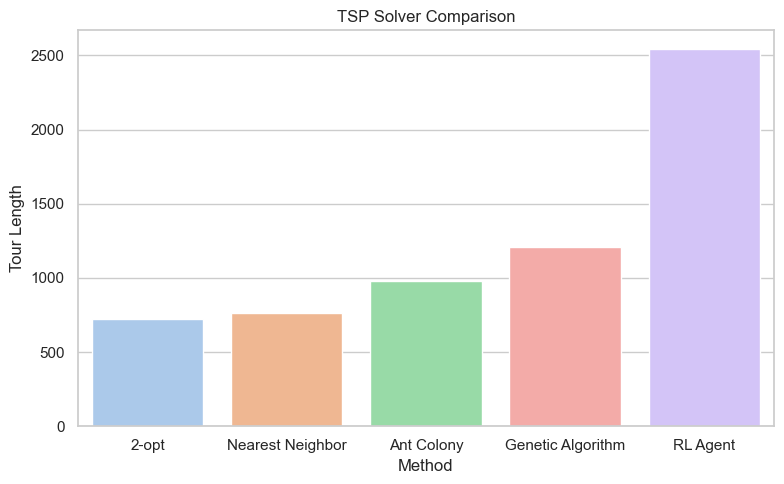

In [97]:
plt.figure(figsize=(8, 5))
sns.barplot(x="Method", y="Tour Length", data=summary_df, palette="pastel")
plt.title("TSP Solver Comparison")
plt.ylabel("Tour Length")
plt.tight_layout()
save_last_plot("method_comparison_bar.png")
save_last_plot("ga_tour_preview.png")
plt.show()


✅ Saved to outputs/instance_map.png
✅ Saved to outputs/nn_tour.png
✅ Saved to outputs/2opt_tour.png
✅ Saved to outputs/ga_tour.png
✅ Saved to outputs/aco_tour.png
✅ Saved to outputs/rl_tour.png


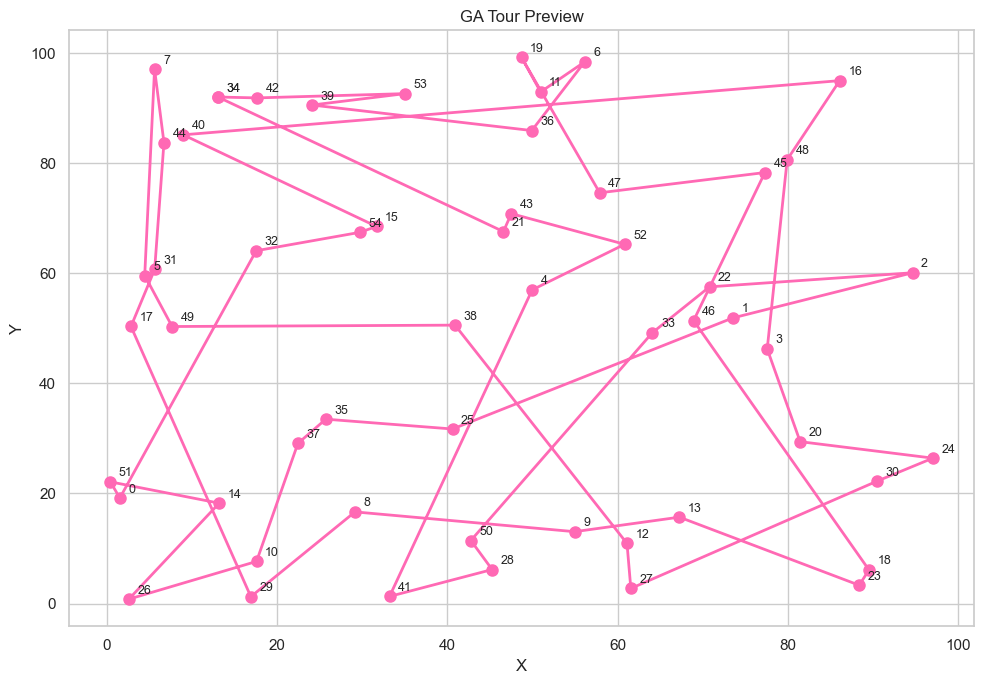

In [98]:
# Static preview since full animation requires notebook magic
plot_tour(coords, ga_tour + [ga_tour[0]], "GA Tour Preview")


In [99]:
import matplotlib.animation as animation

def animate_tour(coords, tour, filename="tour_animation.gif", interval=200):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlim(coords[:, 0].min() - 10, coords[:, 0].max() + 10)
    ax.set_ylim(coords[:, 1].min() - 10, coords[:, 1].max() + 10)
    ax.set_title("Animated TSP Tour")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid(True)

    line, = ax.plot([], [], 'o-', color='deeppink', linewidth=2, markersize=6)

    def init():
        line.set_data([], [])
        return line,

    def update(frame):
        current_tour = tour[:frame + 1]
        tour_coords = coords[current_tour]
        line.set_data(tour_coords[:, 0], tour_coords[:, 1])
        return line,

    ani = animation.FuncAnimation(fig, update, frames=len(tour), init_func=init, blit=True, interval=interval)
    
    # Save animation
    from pathlib import Path
    output_path = Path("../outputs") / filename
    ani.save(output_path, writer='pillow')
    print(f"✅ Animation saved to {output_path}")

    plt.close()

# ▶️ Example usage with GA tour:
animate_tour(coords, ga_tour + [ga_tour[0]], "ga_animated_tour.gif")


✅ Animation saved to ..\outputs\ga_animated_tour.gif


In [100]:
print("🎉 All methods evaluated and saved.")


🎉 All methods evaluated and saved.
